In [1]:
import sys

sys.path.append('../src')

from swfilter import SlicedWassersteinFilter

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from scipy.io import arff
import mlflow
import seaborn as sns


First, run this from terminal :

mlflow server --host 127.0.0.1 --port 8081

In [34]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# Create a new MLflow Experiment
experiment_id = "swfilter_exp_gridsearch_v2"
experiment = mlflow.set_experiment(experiment_id)

# Get Experiment Details
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Name: {}".format(experiment.name))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

2024/08/05 09:21:00 INFO mlflow.tracking.fluent: Experiment with name 'swfilter_exp_gridsearch_v2' does not exist. Creating a new experiment.


Experiment_id: 587539537557778910
Artifact Location: mlflow-artifacts:/587539537557778910
Name: swfilter_exp_gridsearch_v2
Tags: {}
Lifecycle_stage: active


In [35]:
dataset_list = [['Pima', 'Pima_withoutdupl_norm_35'],
                 ['Arrhythmia', 'Arrhythmia_withoutdupl_norm_46'],
                ['WPBC','WPBC_withoutdupl_norm'],
                ['Shuttle', 'Shuttle_withoutdupl_norm_v01'],
                ['Glass', 'Glass_withoutdupl_norm'],
                ['Ionosphere','Ionosphere_withoutdupl_norm'],
                ['Lymphography','Lymphography_withoutdupl_norm_idf'],
                #['Cardiotocography','Cardiotocography_withoutdupl_norm_22']
                ]

In [36]:
def import_dataset(folder_name:str, dataset_name:str)->pd.DataFrame:
    arff_file = arff.loadarff(f'../datasets/{folder_name}/{dataset_name}.arff')
    df_file = pd.DataFrame(arff_file[0])
    features = df_file.drop(columns=['outlier', 'id'])
    label = df_file['outlier']
    return features, label, df_file

def generate_data(folder_name:str, dataset_name:str, test_size:float=0.5, seed:int=42):
    features, label, df_file = import_dataset(folder_name, dataset_name)
    X = np.array(features.values)
    y = np.array(label.values == b'yes')
    y= np.where(y, -1, 1)

    if test_size == 1.0:
        X_test = X
        Y_test = y
        X_train = None 
        Y_train = None
    else:
        X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, y, test_size=test_size, random_state=seed)
    data = {'X_train':X_train, 'X_test':X_test, 'Y_train':Y_train, 'Y_test':Y_test, 'X':X, 'y':y}
    return data

    

## hyperopt

In [37]:
from hyperopt import hp, fmin, tpe, anneal, Trials, STATUS_OK,  pyll
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, make_scorer
from functools import partial
import mlflow


# Adjusting the objective functions to include cross-validation on training data and evaluation on testing data

def objective_lof(space, X_train, Y_train, X_test, Y_test, experiment_id, dataset_name):
    mlflow.set_experiment(experiment_id)
    with mlflow.start_run():
        n_neighbors = int(space['n_neighbors'])
        algorithm = space['algorithm']
        leaf_size = int(space['leaf_size'])
        metric = space['metric']
        
        model = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            algorithm=algorithm,
            leaf_size=leaf_size,
            metric=metric,
            novelty=False
        )
        
        # Cross-validation on training data
        #cv_score = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring).mean()
    
        if X_train is not None:
            # Fit the model on the entire training dataset
            Y_pred = model.fit_predict(X_train)
            train_precision = sk.metrics.precision_score(Y_train, Y_pred, zero_division=0)
            train_accuracy = sk.metrics.accuracy_score(Y_train, Y_pred)
            mlflow.log_metric("train_precision", train_precision)
            mlflow.log_metric("train_accuracy", train_accuracy)

        
        # Evaluate on the testing data
        Y_pred = model.fit_predict(X_test)
        test_accuracy = sk.metrics.accuracy_score(Y_test, Y_pred)
        test_precision = sk.metrics.precision_score(Y_test, Y_pred, zero_division=0)
        test_recall_score = sk.metrics.recall_score(Y_test, Y_pred, zero_division=0)
        
        true_positive = np.sum((Y_test == -1) & (Y_pred == -1))
        false_positive = np.sum((Y_test == 1) & (Y_pred == -1))
        true_negative = np.sum((Y_test == 1) & (Y_pred == 1))
        false_negative = np.sum((Y_test == -1) & (Y_pred == 1))
        mlflow.log_metric("true_positive", true_positive)
        mlflow.log_metric("false_positive", false_positive)
        mlflow.log_metric("true_negative", true_negative)
        mlflow.log_metric("false_negative", false_negative)
        
        # Log parameters, cross-validation score, and testing score
        mlflow.log_param("n_neighbors", n_neighbors)
        mlflow.log_param("algorithm", algorithm)
        mlflow.log_param("leaf_size", leaf_size)
        mlflow.log_param("metric", metric)
        mlflow.log_param("dataset_name", dataset_name)
        
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall_score", test_recall_score)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.set_tag("model", "LocalOutlierFactor")
        
        return {'loss': -train_precision, 'status': STATUS_OK}

def objective_forest(space, X_train, Y_train, X_test, Y_test, experiment_id, dataset_name):
    mlflow.set_experiment(experiment_id)
    with mlflow.start_run():
        n_estimators = int(space['n_estimators'])
        max_samples = int(space['max_samples'])
        contamination = space['contamination']
        max_features = int(space['max_features'])
        
        model = IsolationForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            max_features=max_features,
            random_state=42
        )
        
        # Cross-validation on training data
        #cv_score = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring).mean()
        if X_train is not None:
            # Fit the model on the entire training dataset
            Y_pred = model.fit_predict(X_train)
            train_precision = sk.metrics.precision_score(Y_train, Y_pred, zero_division=0)
            train_accuracy = sk.metrics.accuracy_score(Y_train, Y_pred)
            mlflow.log_metric("train_precision", train_precision)
            mlflow.log_metric("train_accuracy", train_accuracy)

        
        # Evaluate on the testing data
        Y_pred = model.fit_predict(X_test)
        test_accuracy = sk.metrics.accuracy_score(Y_test, Y_pred)
        test_precision = sk.metrics.precision_score(Y_test, Y_pred, zero_division=0)
        test_recall_score = sk.metrics.recall_score(Y_test, Y_pred, zero_division=0)
        
        true_positive = np.sum((Y_test == -1) & (Y_pred == -1))
        false_positive = np.sum((Y_test == 1) & (Y_pred == -1))
        true_negative = np.sum((Y_test == 1) & (Y_pred == 1))
        false_negative = np.sum((Y_test == -1) & (Y_pred == 1))
        mlflow.log_metric("true_positive", true_positive)
        mlflow.log_metric("false_positive", false_positive)
        mlflow.log_metric("true_negative", true_negative)
        mlflow.log_metric("false_negative", false_negative)
        
        # Log parameters, cross-validation score, and testing score
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_samples", max_samples)
        mlflow.log_param("contamination", contamination)
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("dataset_name", dataset_name)
       
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_recall_score", test_recall_score)
        mlflow.set_tag("model", "IsolationForest")
        
        return {'loss': -train_precision, 'status': STATUS_OK}
    

def objective_sw(space, X_train, Y_train, X_test, Y_test, experiment_id, dataset_name):
    mlflow.set_experiment(experiment_id)
    with mlflow.start_run():
        eps = float(space['eps'])
        n = int(space['n'])
        n_projections = int(space['n_projections'])
        p = float(space['p'])
        
        
        model = SlicedWassersteinFilter(
            eps=eps,
            n=n,
            n_projections=n_projections,
            p=p,
            seed=42,
            n_jobs=-1,
            swtype='original'  # Assuming a seed parameter is available for reproducibility
        )
        
        if X_train is not None:
            # Fit the model on the entire training dataset
            Y_pred, vote = model.fit_predict(X_train)
            train_accuracy = sk.metrics.accuracy_score(Y_train, Y_pred)
            train_precision = sk.metrics.precision_score(Y_train, Y_pred, zero_division=0)
            mlflow.log_metric("train_accuracy", train_accuracy)
            mlflow.log_metric("train_precision", train_precision)
        

        # Fit the model on the entire training dataset
        Y_pred, vote = model.fit_predict(X_test)
        test_precision = sk.metrics.precision_score(Y_test, Y_pred, zero_division=0)
        test_accuracy = sk.metrics.accuracy_score(Y_test, Y_pred)
        test_recall_score = sk.metrics.recall_score(Y_test, Y_pred, zero_division=0)
        
        true_positive = np.sum((Y_test == -1) & (Y_pred == -1))
        false_positive = np.sum((Y_test == 1) & (Y_pred == -1))
        true_negative = np.sum((Y_test == 1) & (Y_pred == 1))
        false_negative = np.sum((Y_test == -1) & (Y_pred == 1))
        mlflow.log_metric("true_positive", true_positive)
        mlflow.log_metric("false_positive", false_positive)
        mlflow.log_metric("true_negative", true_negative)
        mlflow.log_metric("false_negative", false_negative)

        # Log parameters, cross-validation score, and testing score
        mlflow.log_param("eps", eps)
        mlflow.log_param("n", n)
        mlflow.log_param("n_projections", n_projections)
        mlflow.log_param("p", p)
        mlflow.log_param("dataset_name", dataset_name)

        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_recall_score", test_recall_score)
        mlflow.set_tag("model", "SlicedWassersteinFilter")
        
        if X_train is None:
            return {'loss': -test_precision, 'status': STATUS_OK}
        else:
            return {'loss': -train_precision, 'status': STATUS_OK}

from hyperopt.base import miscs_update_idxs_vals
from hyperopt.pyll.base import dfs, as_apply
from hyperopt.pyll.stochastic import implicit_stochastic_symbols
# https://github.com/hyperopt/hyperopt/issues/200


class ExhaustiveSearchError(Exception):
    pass


def validate_space_exhaustive_search(space):
    supported_stochastic_symbols = ['randint', 'quniform', 'qloguniform', 'qnormal', 'qlognormal', 'categorical']
    for node in dfs(as_apply(space)):
        if node.name in implicit_stochastic_symbols:
            if node.name not in supported_stochastic_symbols:
                raise ExhaustiveSearchError('Exhaustive search is only possible with the following stochastic symbols: ' + ', '.join(supported_stochastic_symbols))


def suggest(new_ids, domain, trials, seed, nbMaxSucessiveFailures=1000):

    # Build a hash set for previous trials
    hashset = set([hash(frozenset([(key, value[0]) if len(value) > 0 else ((key, None))
                                   for key, value in trial['misc']['vals'].items()])) for trial in trials.trials])

    rng =  np.random.default_rng(seed)#np.random.RandomState(seed)
    rval = []
    for _, new_id in enumerate(new_ids):
        newSample = False
        nbSucessiveFailures = 0
        while not newSample:
            # -- sample new specs, idxs, vals
            idxs, vals = pyll.rec_eval(
                domain.s_idxs_vals,
                memo={
                    domain.s_new_ids: [new_id],
                    domain.s_rng: rng,
                })
            new_result = domain.new_result()
            new_misc = dict(tid=new_id, cmd=domain.cmd, workdir=domain.workdir)
            miscs_update_idxs_vals([new_misc], idxs, vals)

            # Compare with previous hashes
            h = hash(frozenset([(key, value[0]) if len(value) > 0 else (
                (key, None)) for key, value in vals.items()]))
            if h not in hashset:
                newSample = True
            else:
                # Duplicated sample, ignore
                nbSucessiveFailures += 1
            
            if nbSucessiveFailures > nbMaxSucessiveFailures:
                # No more samples to produce
                return []

        rval.extend(trials.new_trial_docs([new_id],
                                          [None], [new_result], [new_misc]))
    return rval

In [38]:
lof_bool = False
forest_bool = False
sw_bool = True

#scoring = make_scorer(precision_score, zero_division=0)
max_evals = 300

In [39]:
for dataset in dataset_list:
    
    dataset_name = dataset[0]
    data = generate_data(dataset[0], dataset[1], test_size=1.0, seed=42)
    X_train = data['X_train']
    X_test = data['X_test']
    Y_train = data['Y_train']
    Y_test = data['Y_test']
    X = data['X']
    y = data['y']
    

    

    

    if lof_bool:
        # Define search spaces
        space_lof = {
            'n_neighbors': hp.quniform('n_neighbors', 10, 100,1),
            'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': hp.quniform('leaf_size', 5, 100, 1),
            'metric': hp.choice('metric', ['euclidean', 'manhattan', 'chebyshev', 'minkowski'])
        }
        validate_space_exhaustive_search(space_lof)
        # Example of running a trial for LOF with the partial function
        objective_lof_partial = partial(objective_lof, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, experiment_id=experiment_id, dataset_name=dataset_name)

        trials_lof = Trials()
        best_lof = fmin(fn=objective_lof_partial,
                        space=space_lof,
                        algo=anneal.suggest,
                        max_evals=max_evals,
                        trials=trials_lof)

    if forest_bool:
        space_forest = {
        'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
        'max_samples': hp.quniform('max_samples', 1, X_test.shape[0],1),
        'contamination': hp.loguniform('contamination', -7, -0.7),
        'max_features': hp.quniform('max_features', 1, X_test.shape[1], 1)
         }
        validate_space_exhaustive_search(space_forest)
        objective_forest_partial = partial(objective_forest, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, experiment_id=experiment_id, dataset_name=dataset_name)

        trials_iforest = Trials()
        best_iforest = fmin(fn=objective_forest_partial,
                            space=space_forest,
                            algo=anneal.suggest,
                            max_evals=max_evals,
                            trials=trials_iforest)

    if sw_bool:
        space_sw = {
        'eps': hp.loguniform('eps', -7, 4),
        'n': hp.quniform('n', 10, 100, 1),
        'n_projections': hp.quniform('n_projections', 50, 200, 1),
        'p': hp.uniform('p', 0.6, 1),

        }

        space_sw_discrete = {
            'eps': hp.choice('eps', [0.00001,  0.0001,  0.001,  0.01,  0.1 , 1, 10, 100, 1000]),
            'n': hp.choice('n', [25, 75]),
            'n_projections': hp.choice('n_projections', [100, 200]),
            'p': hp.choice('p', [0.5, 0.7, 0.9]),

        }
        print(validate_space_exhaustive_search(space_sw_discrete))
        objective_sw_partial = partial(objective_sw, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test,  experiment_id=experiment_id, dataset_name=dataset_name)

        # Example of running a trial for SlicedWassersteinFilter with the partial function
        trials_sw = Trials()
        best_sw = fmin(fn=objective_sw_partial,
                    space=space_sw_discrete,
                    algo=partial(suggest, nbMaxSucessiveFailures=1000),
                    max_evals=np.inf,
                    trials=trials_sw)

None
108trial [1:54:50, 63.80s/trial, best loss: -0.6680613668061367] 
None
108trial [37:47, 20.99s/trial, best loss: -0.6325966850828729]
None
108trial [04:33,  2.53s/trial, best loss: -0.7626262626262627]
None
108trial [3:38:23, 121.33s/trial, best loss: -1.0]            
None
108trial [05:21,  2.98s/trial, best loss: -1.0]              
None
108trial [16:25,  9.13s/trial, best loss: -1.0]              
None
108trial [02:27,  1.36s/trial, best loss: -1.0]             


## Extract results

In [45]:
df = mlflow.search_runs([experiment.experiment_id],filter_string="status = 'FINISHED'")
#building_ids = df['params.building_id']
display(df)
datasets = df['params.dataset_name'].unique()
print(datasets)
models = ['SlicedWassersteinFilter'] #'IsolationForest', 'LocalOutlierFactor']

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.true_negative,metrics.false_positive,metrics.test_recall_score,metrics.false_negative,...,params.p,params.eps,params.n,params.dataset_name,params.n_projections,tags.mlflow.source.name,tags.mlflow.runName,tags.model,tags.mlflow.source.type,tags.mlflow.user
0,cc4784415a874ff9b7204b0894d14f9c,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/cc4784415...,2024-08-05 20:01:11.338000+00:00,2024-08-05 20:01:12.586000+00:00,139.0,3.0,0.978873,0.0,...,0.5,0.01,75,Lymphography,100,/home/julien/.local/lib/python3.10/site-packag...,painted-bass-785,SlicedWassersteinFilter,LOCAL,julien
1,265d192ec47845a1a2472fe119d64d16,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/265d192ec...,2024-08-05 20:01:10.807000+00:00,2024-08-05 20:01:11.272000+00:00,142.0,0.0,1.000000,6.0,...,0.7,10.0,25,Lymphography,100,/home/julien/.local/lib/python3.10/site-packag...,ambitious-carp-483,SlicedWassersteinFilter,LOCAL,julien
2,00eca04866b14446b50b4bb3f859970b,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/00eca0486...,2024-08-05 20:01:09.852000+00:00,2024-08-05 20:01:10.758000+00:00,142.0,0.0,1.000000,6.0,...,0.9,1.0,25,Lymphography,200,/home/julien/.local/lib/python3.10/site-packag...,aged-frog-683,SlicedWassersteinFilter,LOCAL,julien
3,ca37198e696e409da8f53c0f96df0c65,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/ca37198e6...,2024-08-05 20:01:08.533000+00:00,2024-08-05 20:01:09.804000+00:00,142.0,0.0,1.000000,6.0,...,0.7,1000.0,75,Lymphography,100,/home/julien/.local/lib/python3.10/site-packag...,shivering-kit-111,SlicedWassersteinFilter,LOCAL,julien
4,d0f4b5e6f91e42f6ab71e68161adddc8,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/d0f4b5e6f...,2024-08-05 20:01:08.026000+00:00,2024-08-05 20:01:08.489000+00:00,139.0,3.0,0.978873,0.0,...,0.5,0.01,25,Lymphography,100,/home/julien/.local/lib/python3.10/site-packag...,peaceful-snipe-842,SlicedWassersteinFilter,LOCAL,julien
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,29f56d5a295b4a71b4f2f91f8c747499,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/29f56d5a2...,2024-08-05 13:25:09.735000+00:00,2024-08-05 13:25:56.330000+00:00,500.0,0.0,1.000000,268.0,...,0.9,100.0,25,Pima,200,/home/julien/.local/lib/python3.10/site-packag...,suave-snipe-699,SlicedWassersteinFilter,LOCAL,julien
752,10d33bb0a2e54e72b7e71b7b35fff72b,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/10d33bb0a...,2024-08-05 13:24:21.706000+00:00,2024-08-05 13:25:09.690000+00:00,0.0,500.0,0.000000,0.0,...,0.7,1e-05,75,Pima,100,/home/julien/.local/lib/python3.10/site-packag...,efficient-auk-193,SlicedWassersteinFilter,LOCAL,julien
753,a4028ed311d646de8ef18dc948f6bb88,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/a4028ed31...,2024-08-05 13:24:05.305000+00:00,2024-08-05 13:24:21.660000+00:00,0.0,500.0,0.000000,0.0,...,0.9,0.0001,25,Pima,100,/home/julien/.local/lib/python3.10/site-packag...,bedecked-shrike-802,SlicedWassersteinFilter,LOCAL,julien
754,28849a362ed948019c2f8c6c908ce41b,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/28849a362...,2024-08-05 13:21:42.538000+00:00,2024-08-05 13:24:05.259000+00:00,470.0,30.0,0.940000,237.0,...,0.5,0.001,75,Pima,200,/home/julien/.local/lib/python3.10/site-packag...,caring-koi-652,SlicedWassersteinFilter,LOCAL,julien


['Lymphography' 'Ionosphere' 'Glass' 'Shuttle' 'WPBC' 'Arrhythmia' 'Pima']


In [51]:
import json
result_dict = {}

for dataset in datasets:
    for model in models:
        best_val= df.loc[(df['params.dataset_name'] == dataset) & (df['tags.model'] == model)].sort_values(by=['metrics.test_precision', 'end_time'], ascending=True).tail(1)

        #best_mse = df.loc[(df['params.benchmark_functions'] == function) & (df['tags.model_name'] == model)].sort_values(by='metrics.MSE_val', ascending=True).head(1)
        #best_build = df.loc[ (df['tags.model_name'] == model)].sort_values(by='metrics.MAE_VAL_all_buildings_scaled', ascending=True).head(1)

        if f'{dataset}' not in result_dict.keys():
            result_dict[f'{dataset}'] = {}

        display(best_val)
       
        result_dict[f'{dataset}'][f'{model}'] = {'test_accuracy': best_val['metrics.test_accuracy'].values[0], 'test_precision' : best_val['metrics.test_precision'].values[0]}



,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.true_negative,metrics.false_positive,metrics.test_recall_score,metrics.false_negative,...,params.p,params.eps,params.n,params.dataset_name,params.n_projections,tags.mlflow.source.name,tags.mlflow.runName,tags.model,tags.mlflow.source.type,tags.mlflow.user
0,cc4784415a874ff9b7204b0894d14f9c,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/cc4784415...,2024-08-05 20:01:11.338000+00:00,2024-08-05 20:01:12.586000+00:00,139.0,3.0,0.978873,0.0,...,0.5,0.01,75,Lymphography,100,/home/julien/.local/lib/python3.10/site-packag...,painted-bass-785,SlicedWassersteinFilter,LOCAL,julien


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.true_negative,metrics.false_positive,metrics.test_recall_score,metrics.false_negative,...,params.p,params.eps,params.n,params.dataset_name,params.n_projections,tags.mlflow.source.name,tags.mlflow.runName,tags.model,tags.mlflow.source.type,tags.mlflow.user
111,aea8a221db2d4e1ca0f712b065c9cdde,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/aea8a221d...,2024-08-05 19:58:12.986000+00:00,2024-08-05 19:58:15.577000+00:00,20.0,205.0,0.088889,0.0,...,0.7,0.001,25,Ionosphere,100,/home/julien/.local/lib/python3.10/site-packag...,luxuriant-conch-50,SlicedWassersteinFilter,LOCAL,julien


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.true_negative,metrics.false_positive,metrics.test_recall_score,metrics.false_negative,...,params.p,params.eps,params.n,params.dataset_name,params.n_projections,tags.mlflow.source.name,tags.mlflow.runName,tags.model,tags.mlflow.source.type,tags.mlflow.user
219,e1d27b1835bb4691918cb9807aede4d4,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/e1d27b183...,2024-08-05 19:42:04.118000+00:00,2024-08-05 19:42:10.064000+00:00,44.0,161.0,0.214634,0.0,...,0.5,0.001,75,Glass,200,/home/julien/.local/lib/python3.10/site-packag...,learned-skunk-118,SlicedWassersteinFilter,LOCAL,julien


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.true_negative,metrics.false_positive,metrics.test_recall_score,metrics.false_negative,...,params.p,params.eps,params.n,params.dataset_name,params.n_projections,tags.mlflow.source.name,tags.mlflow.runName,tags.model,tags.mlflow.source.type,tags.mlflow.user
339,64e95eb6fa5e4e8eb243eab5018ba3c9,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/64e95eb6f...,2024-08-05 19:01:42.155000+00:00,2024-08-05 19:02:12.870000+00:00,139.0,861.0,0.139,0.0,...,0.9,0.0001,25,Shuttle,100,/home/julien/.local/lib/python3.10/site-packag...,wistful-sheep-253,SlicedWassersteinFilter,LOCAL,julien


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.true_negative,metrics.false_positive,metrics.test_recall_score,metrics.false_negative,...,params.p,params.eps,params.n,params.dataset_name,params.n_projections,tags.mlflow.source.name,tags.mlflow.runName,tags.model,tags.mlflow.source.type,tags.mlflow.user
432,c00cc14781c4426d97996835874e613d,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/c00cc1478...,2024-08-05 15:58:33.551000+00:00,2024-08-05 15:58:34.333000+00:00,151.0,0.0,1.0,47.0,...,0.7,100.0,25,WPBC,100,/home/julien/.local/lib/python3.10/site-packag...,bittersweet-worm-912,SlicedWassersteinFilter,LOCAL,julien


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.true_negative,metrics.false_positive,metrics.test_recall_score,metrics.false_negative,...,params.p,params.eps,params.n,params.dataset_name,params.n_projections,tags.mlflow.source.name,tags.mlflow.runName,tags.model,tags.mlflow.source.type,tags.mlflow.user
598,a4a5e374a0ec4182ba444cefe699fd83,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/a4a5e374a...,2024-08-05 15:34:15.399000+00:00,2024-08-05 15:34:30.162000+00:00,229.0,15.0,0.938525,133.0,...,0.5,0.001,25,Arrhythmia,200,/home/julien/.local/lib/python3.10/site-packag...,righteous-dog-378,SlicedWassersteinFilter,LOCAL,julien


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.true_negative,metrics.false_positive,metrics.test_recall_score,metrics.false_negative,...,params.p,params.eps,params.n,params.dataset_name,params.n_projections,tags.mlflow.source.name,tags.mlflow.runName,tags.model,tags.mlflow.source.type,tags.mlflow.user
750,cf2a4f94ab364d7182f80a2bdfdb0674,587539537557778910,FINISHED,mlflow-artifacts:/587539537557778910/cf2a4f94a...,2024-08-05 13:25:56.375000+00:00,2024-08-05 13:26:43.679000+00:00,479.0,21.0,0.958,238.0,...,0.9,0.001,75,Pima,100,/home/julien/.local/lib/python3.10/site-packag...,judicious-moth-672,SlicedWassersteinFilter,LOCAL,julien


In [48]:
df_2 = pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in result_dict.items()
    }, 
    axis=0)

In [49]:



data_precision = pd.DataFrame(columns=datasets, index=models)
data_accuracy = pd.DataFrame(columns=datasets, index=models)

for ids in datasets:
        for model in models:
                if ids in df_2['test_precision'] and model and ids is not None:
                        data_accuracy[ids][model] = df_2['test_accuracy'][ids][model]
                        data_precision[ids][model] = df_2['test_precision'][ids][model]
                

                


/tmp/ipykernel_41914/3895824515.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_accuracy[ids][model] = df_2['test_accuracy'][ids][model]
/tmp/ipykernel_41914/3895824515.py:8: FutureWarning: ChainedAssignmentError: behaviour will cha

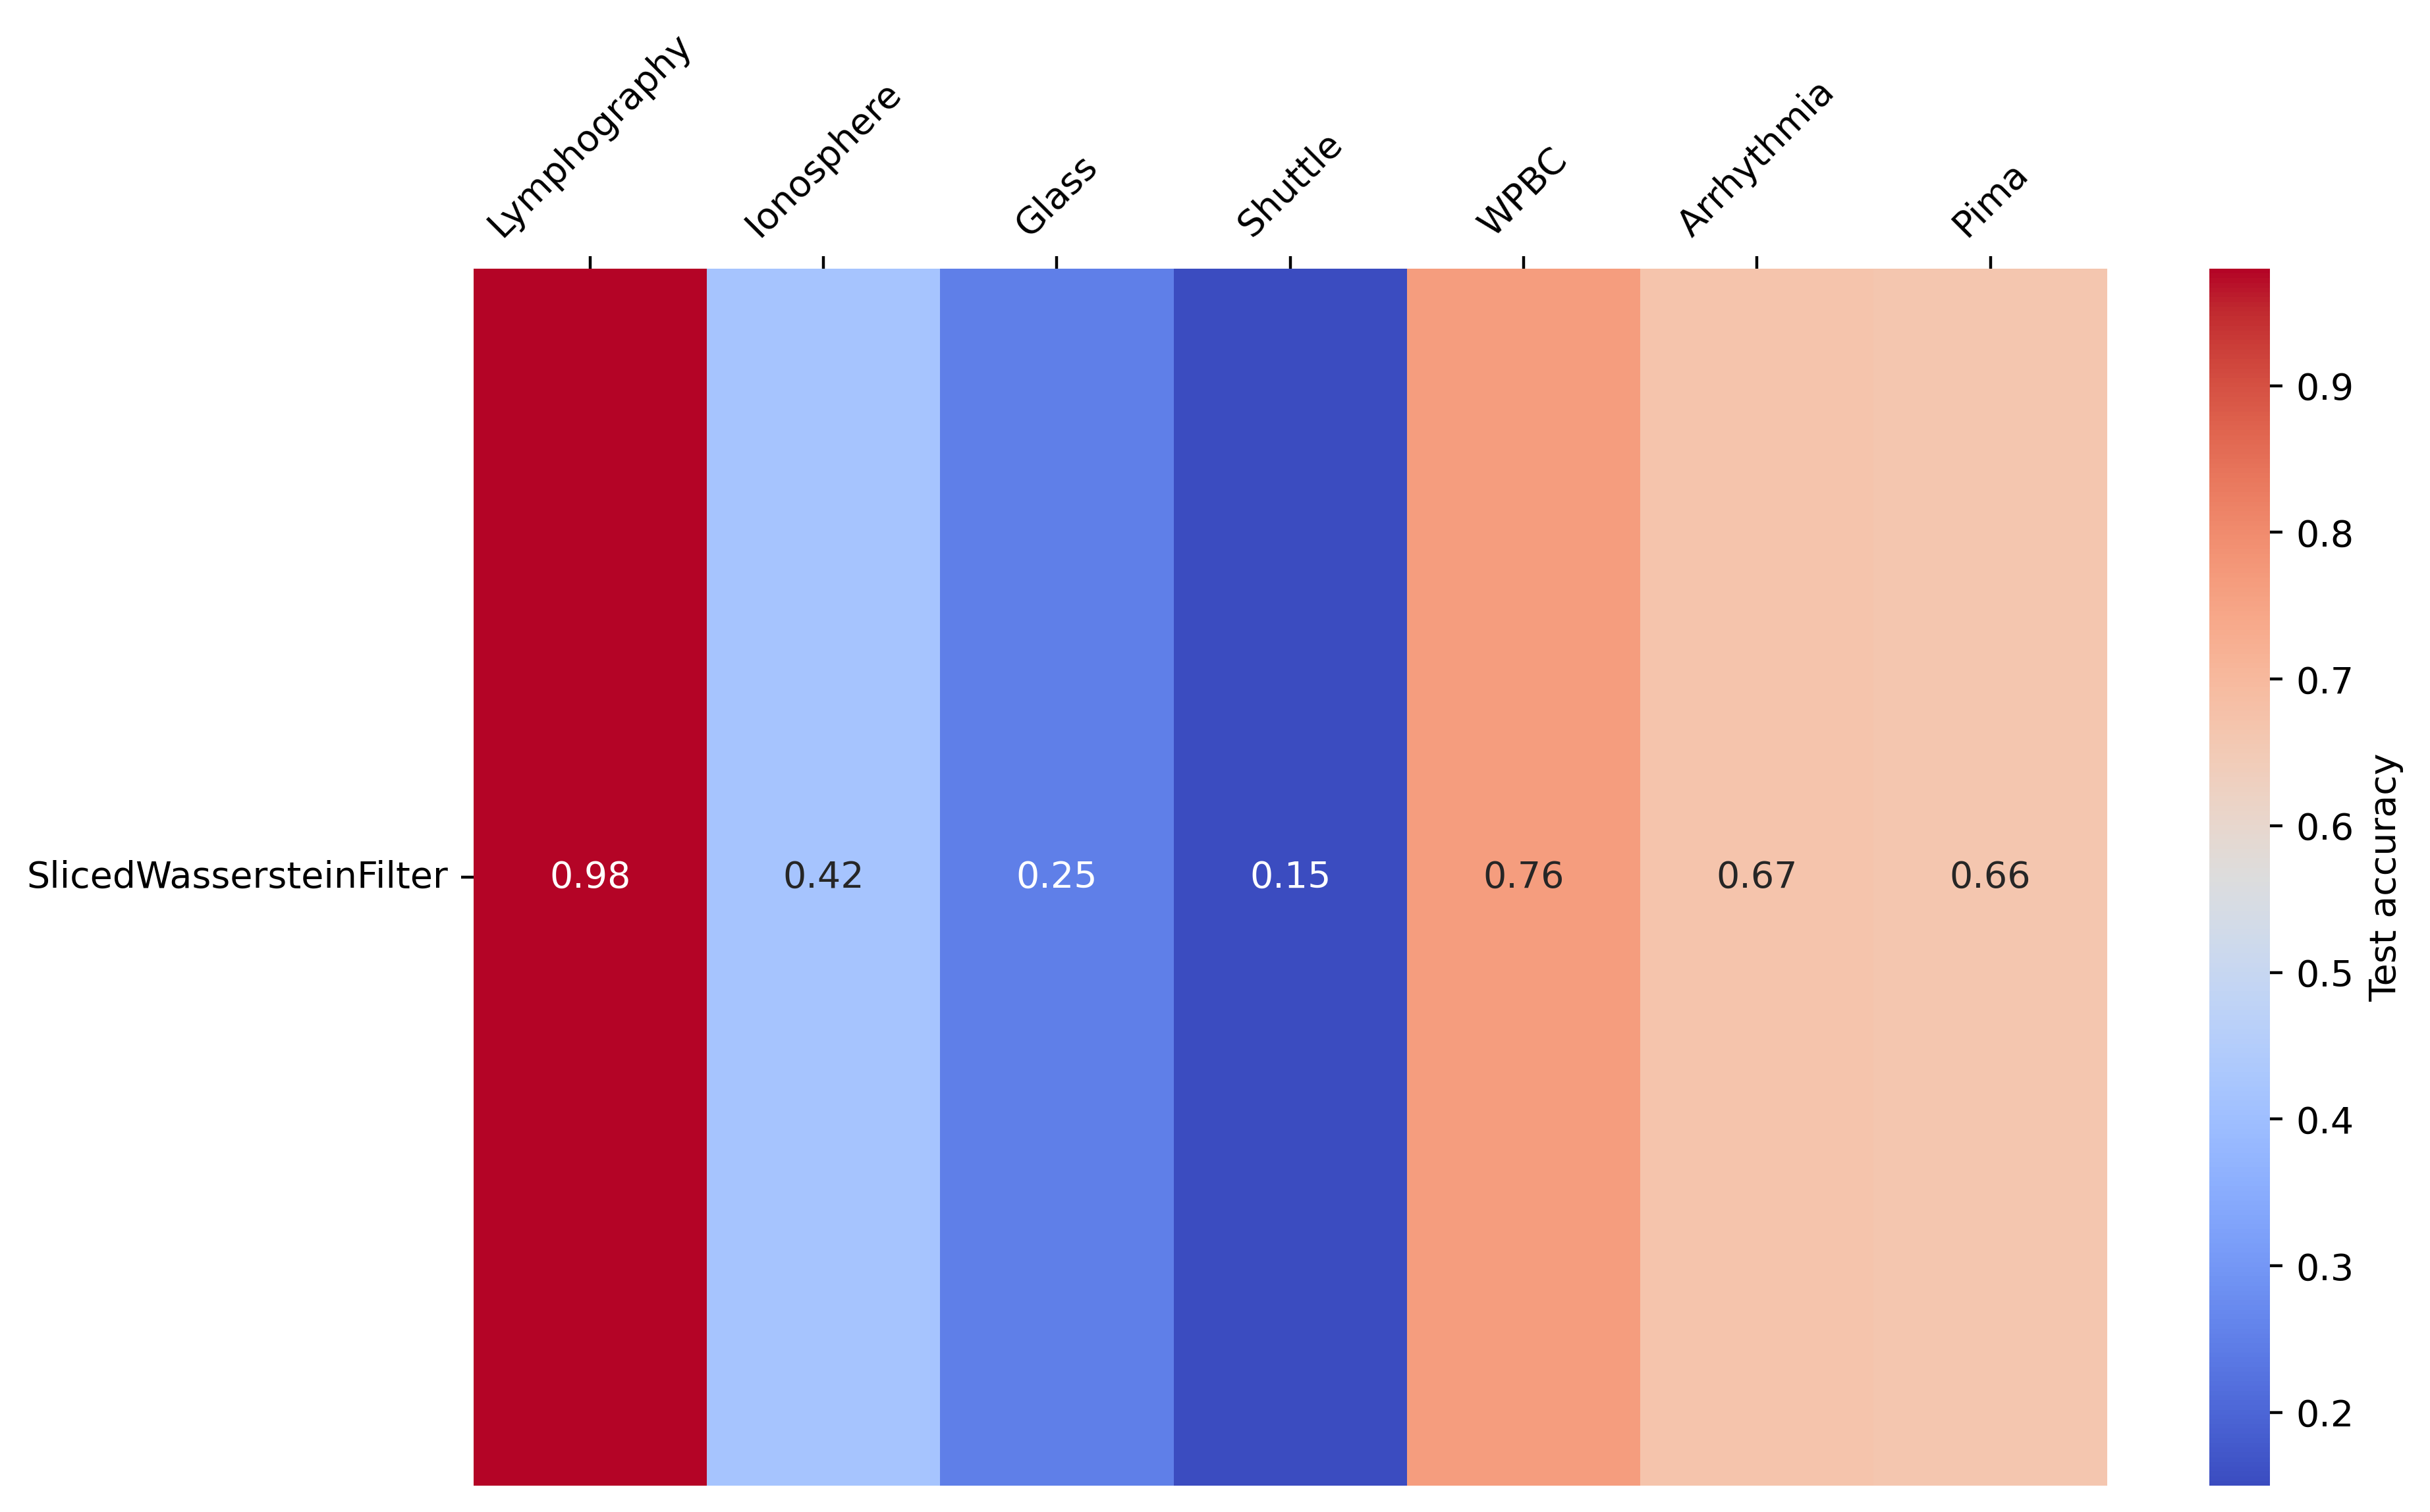

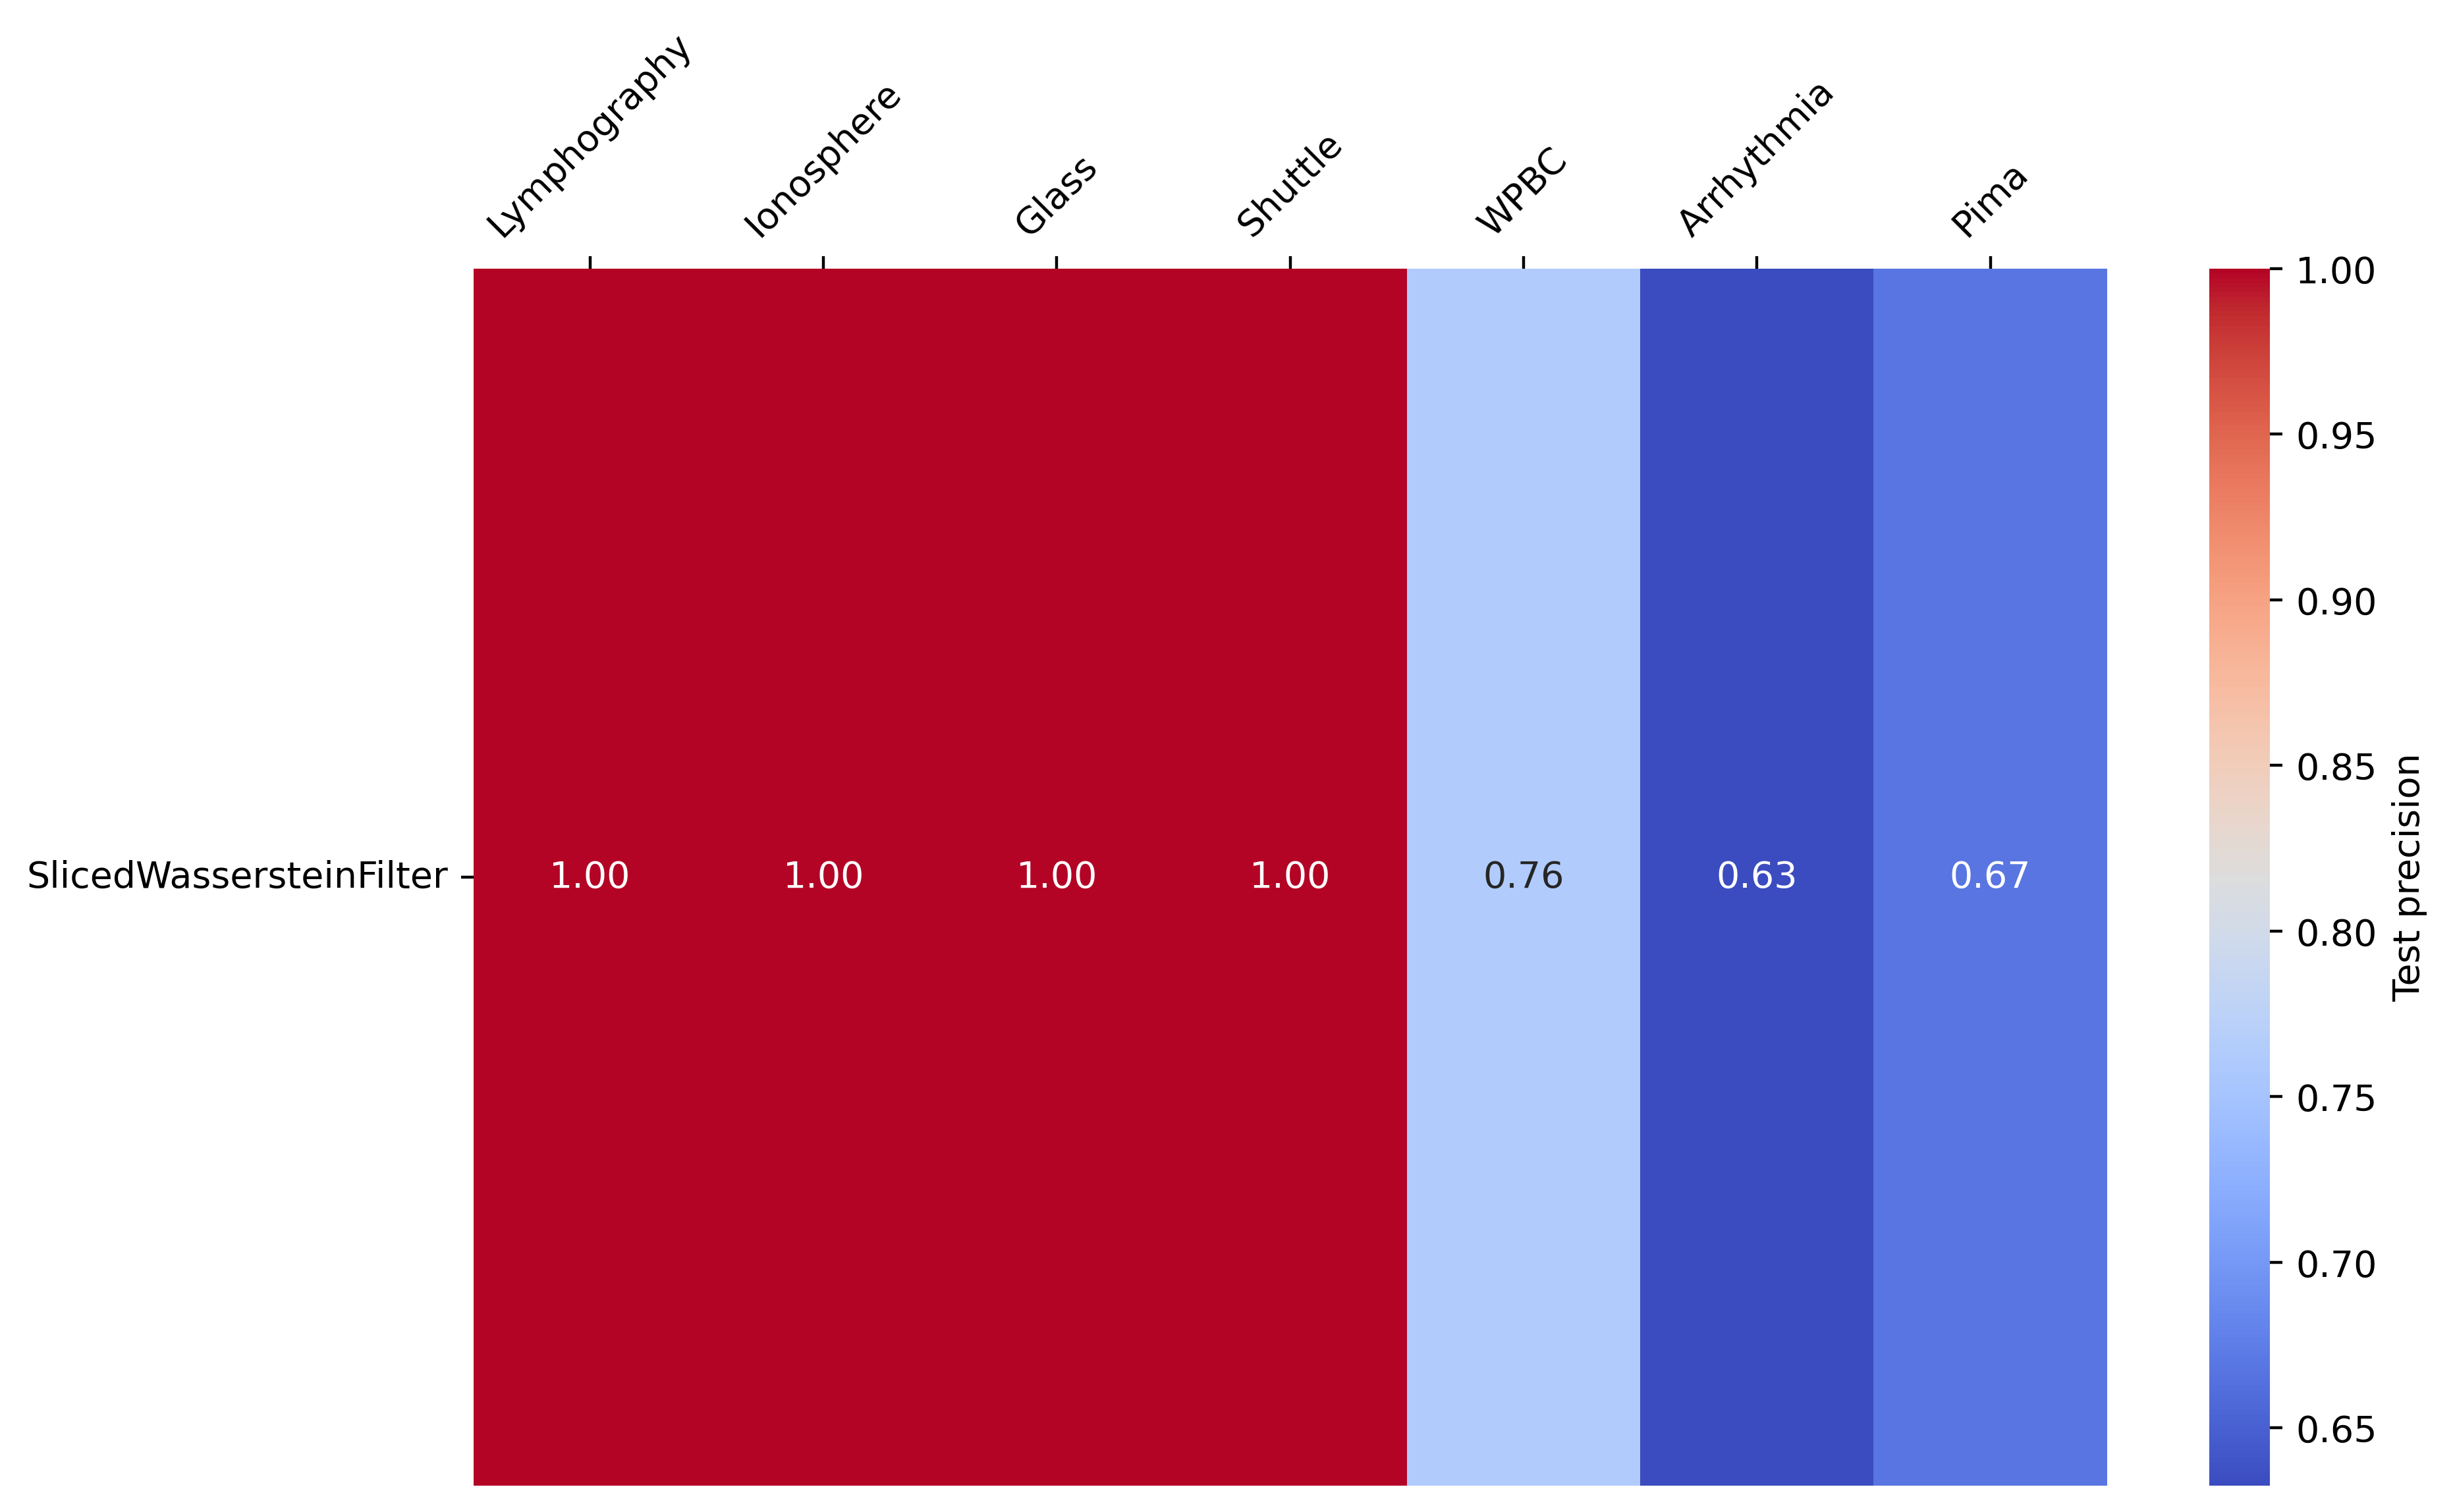

In [50]:
data = data_accuracy
# Normalize each column by its range
data_norm = (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(10, 6), dpi = 400)
#plt.tight_layout()
cmap = sns.color_palette("coolwarm", as_cmap=True)
heatmap = sns.heatmap(data.astype(float), cmap=cmap, annot=True, fmt=".2f",cbar_kws={'label': 'Test accuracy'})

# Set the function names as the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Set the function names as the x-axis labels and place them on top
heatmap.set_xticklabels(data.columns, rotation=45)
heatmap.xaxis.tick_top()

#plt.title('Your caption here', y=-0.1)
#plt.title('Normalized error metrics for different models and benchmark functions')
#plt.savefig('heatmap_JOPT.pdf', bbox_inches='tight')
plt.show()

data = data_precision
data_norm = (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(10, 6), dpi = 400)
#plt.tight_layout()
cmap = sns.color_palette("coolwarm", as_cmap=True)
heatmap = sns.heatmap(data.astype(float), cmap=cmap, annot=True, fmt=".2f",cbar_kws={'label': 'Test precision'})

# Set the function names as the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Set the function names as the x-axis labels and place them on top
heatmap.set_xticklabels(data.columns, rotation=45)
heatmap.xaxis.tick_top()

#plt.title('Your caption here', y=-0.1)
#plt.title('Normalized error metrics for different models and benchmark functions')
#plt.savefig('heatmap_JOPT.pdf', bbox_inches='tight')
plt.show()
